In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import pandas as pd
from glob import glob
import pylab
import os
import seaborn as sns
from matplotlib.patches import Rectangle
import csv
import random
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import gc


det_class = 'C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_detailed_class_info.csv'
boxes = 'C:/Users/Niyati/Desktop/Northeastern/FAI/project/stage_2_train_labels.csv'

ModuleNotFoundError: No module named 'pydicom'

30227 class infos loaded
26684 patient cases


,patientId,class
27750,f639bed9-c6f3-4cf6-ac10-448b147d0e4f,No Lung Opacity / Not Normal
15938,9aafb748-85b2-422a-8061-84105d80330a,No Lung Opacity / Not Normal
28877,ff3258f3-2c66-40cf-9d5d-fe77f8036fa6,Lung Opacity


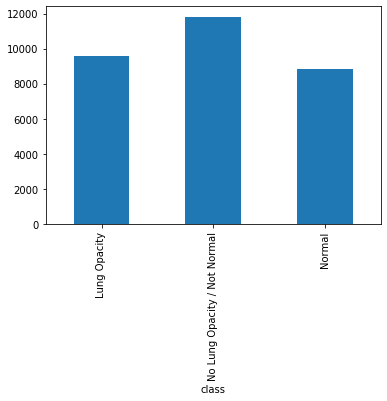

In [2]:
det_class_df = pd.read_csv(det_class)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)


In [3]:
boxes_df = pd.read_csv(boxes)
print(boxes_df.shape[0], 'boxes')
print(boxes_df['patientId'].value_counts().shape[0], 'patient cases')
boxes_df.sample(10)

30227 boxes
26684 patient cases


,patientId,x,y,width,height,Target
10850,7251ea5b-92d5-4474-8f1c-462c204923bf,NaN,NaN,NaN,NaN,0
4097,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,87.0,104.0,310.0,793.0,1
913,0b652c84-50b1-4fa9-8704-94d90827c879,NaN,NaN,NaN,NaN,0
4878,4217397c-f5d1-4890-8d71-5c6eebf8340e,183.0,382.0,246.0,195.0,1
10072,6c499ba1-df4c-4b47-b81e-34ded09a9dc4,635.0,248.0,206.0,409.0,1
12196,7cf4a9ef-0192-432d-bcf4-b4f8ebb3704a,249.0,257.0,158.0,188.0,1
22945,ceef121b-c068-439c-9143-5f16cff925fb,NaN,NaN,NaN,NaN,0
15341,9608e9bd-9cf6-4707-b40c-6218f4ce0d4a,NaN,NaN,NaN,NaN,0
16598,a058e58a-be32-4941-86ce-b01a36285658,133.0,124.0,336.0,720.0,1
1834,192f8bc4-1d12-4b3e-84a6-d94f77928faf,508.0,287.0,312.0,618.0,1


In [4]:
combined_df = pd.merge(boxes_df, det_class_df, how='inner', on='patientId')
print(combined_df.shape[0], 'combined cases')

37629 combined cases


In [5]:
combined_df = pd.concat([boxes_df, 
                        det_class_df.drop('patientId',1)], 1)
print(combined_df.shape[0], 'combined cases')
combined_df.sample(10)
forSVM_df = combined_df


30227 combined cases


In [6]:
final = combined_df.dropna()
print(final.shape[0], 'combined cases')
final.sample(10)

9555 combined cases


,patientId,x,y,width,height,Target,class
28404,fb771e55-ad38-4f26-8eee-30573851bc48,231.0,486.0,155.0,127.0,1,Lung Opacity
27864,f736efcc-ac9e-4f00-9e27-03add80f6f63,606.0,403.0,159.0,318.0,1,Lung Opacity
14767,9164c28f-9820-49e5-8020-460bf25c270c,435.0,344.0,313.0,558.0,1,Lung Opacity
21136,bf999eaa-6bce-46f8-be87-1dc34ca20e97,302.0,360.0,124.0,233.0,1,Lung Opacity
10501,6f964e55-2f17-4361-b6f2-3af8e5d6e55a,591.0,271.0,199.0,474.0,1,Lung Opacity
8460,5f8ecc2d-d8b8-4974-b327-7920315c55aa,105.0,540.0,283.0,307.0,1,Lung Opacity
588,08d8e57a-4835-445b-8c79-8dd31ab17819,115.0,577.0,354.0,210.0,1,Lung Opacity
25600,e532c5eb-e94d-42db-89a7-914ed862490f,131.0,479.0,226.0,254.0,1,Lung Opacity
29394,1462ffd1-939b-49b7-9234-eeeb7f4986cc,238.0,354.0,198.0,328.0,1,Lung Opacity
28207,f9c99896-bcb6-45b4-9128-528f695e3628,615.0,482.0,203.0,106.0,1,Lung Opacity


<Figure size 432x288 with 0 Axes>

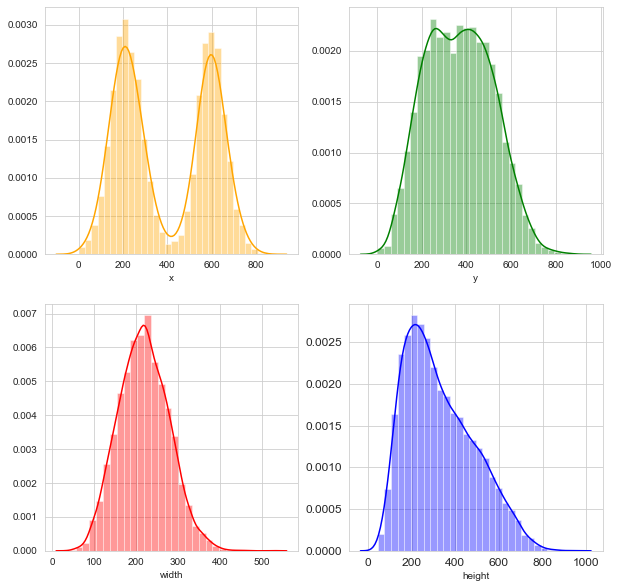

In [7]:
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(10,10))
sns.distplot(final['x'],kde=True,bins=30, color="orange", ax=ax[0,0])
sns.distplot(final['y'],kde=True,bins=30, color="green", ax=ax[0,1])
sns.distplot(final['width'],kde=True,bins=30, color="red", ax=ax[1,0])
sns.distplot(final['height'],kde=True,bins=30, color="blue", ax=ax[1,1])

locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

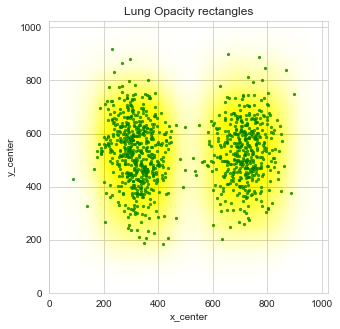

In [8]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
final1 = final.sample(1000)
final1['x_center'] = final1['x'] + final1['width'] / 2
final1['y_center'] = final1['y'] + final1['height'] / 2
plt.title("Lung Opacity rectangles")
final1.plot.scatter(x='x_center', y='y_center', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.7, marker=".", color="green")
for i, sample in final1.iterrows():
    ax.add_patch(Rectangle(xy=(sample['x'], sample['y']),
                width=sample['width'],height=sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [9]:
final.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555


In [10]:
box_df = combined_df.groupby('patientId').size().reset_index(name='boxes')
combined_df = pd.merge(combined_df, box_df, on='patientId')
box_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


In [11]:
box1_df = final.groupby('patientId').size().reset_index(name='boxes1')
final = pd.merge(final, box1_df, on='patientId')
box1_df.groupby('boxes1').size().reset_index(name='patients')

,boxes1,patients
0,1,2614
1,2,3266
2,3,119
3,4,13


In [12]:
images = '/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv'
boxes = '/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'

boxes = pd.read_csv('/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
print(boxes.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [13]:
print(boxes.iloc[8])

patientId    00704310-78a8-4b38-8475-49f4573b2dbb
x                                             323
y                                             577
width                                         160
height                                        104
Target                                          1
Name: 8, dtype: object


In [14]:
patientId = boxes['patientId'][8]
print(patientId)
dicom_file = 'C:/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % patientId
myDICOM = pydicom.read_file(dicom_file)

00704310-78a8-4b38-8475-49f4573b2dbb


In [15]:
image_pixel = myDICOM.pixel_array
print(type(image_pixel))
print(image_pixel.shape)

<class 'numpy.ndarray'>
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

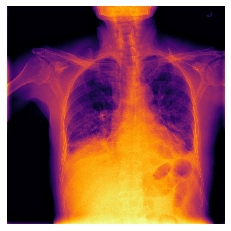

In [16]:
pylab.imshow(image_pixel, cmap=pylab.cm.inferno)
pylab.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

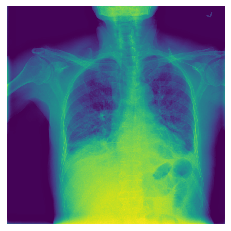

In [17]:
pylab.imshow(image_pixel, cmap=pylab.cm.viridis)
pylab.axis('off')

0004cfab-14fd-4e49-80ba-63a80b6bddd6


(-0.5, 1023.5, 1023.5, -0.5)

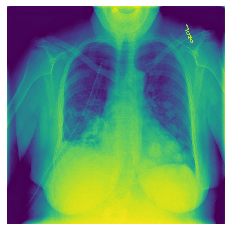

In [18]:
patientId = boxes['patientId'][0]
print(patientId)
dicom_file = 'C:/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % patientId
myDICOM = pydicom.read_file(dicom_file)
image_pixel = myDICOM.pixel_array
pylab.imshow(image_pixel, cmap=pylab.cm.viridis)
pylab.axis('off')

In [19]:
def parse_data(df):
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows(): 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': 'C:/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [20]:
parsed = parse_data(boxes)

In [21]:
def constructBoxes(image):
    d = pydicom.read_file(image['dicom'])
    pixels = d.pixel_array
    #Convert from 3d for rgb pixels
    pixels = np.stack([pixels] * 3, axis=2)

    for box in image['boxes']:
        rgb = [0,255,0]
        pixels = overlay_box(pixels=pixels, box=box, rgb=rgb, stroke=8)
    pylab.imshow(pixels, cmap=pylab.cm.viridis)
    pylab.axis('off')

def overlay_box(pixels, box, rgb, stroke=8):
    #get integers coordinates
    box = [int(b) for b in box]
    
    #get x,y coordinates
    y1, x1, height, width = box
    y2 = y1 + height 
    x2 = x1 + width

    pixels[y1:y1 + stroke, x1:x2] = rgb
    pixels[y2:y2 + stroke, x1:x2] = rgb
    pixels[y1:y2, x1:x1 + stroke] = rgb
    pixels[y1:y2, x2:x2 + stroke] = rgb

    return pixels

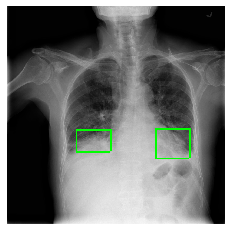

In [22]:
constructBoxes(parsed['00704310-78a8-4b38-8475-49f4573b2dbb'])

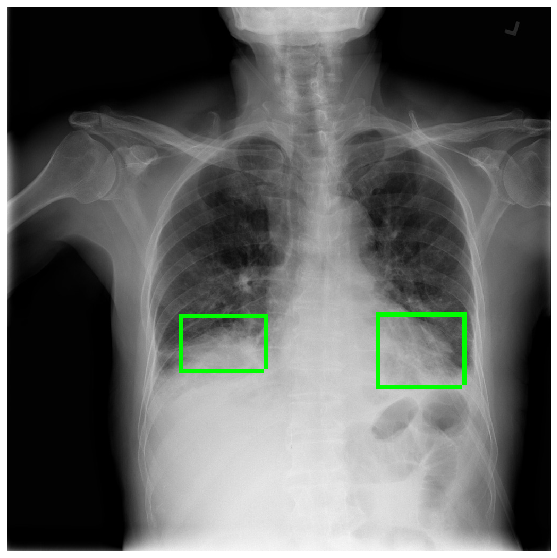

In [23]:
fig=plt.figure(figsize=(20, 10))
constructBoxes(parsed['00704310-78a8-4b38-8475-49f4573b2dbb'])
plt.show()

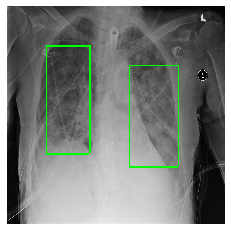

In [24]:
constructBoxes(parsed['00f08de1-517e-4652-a04f-d1dc9ee48593'])

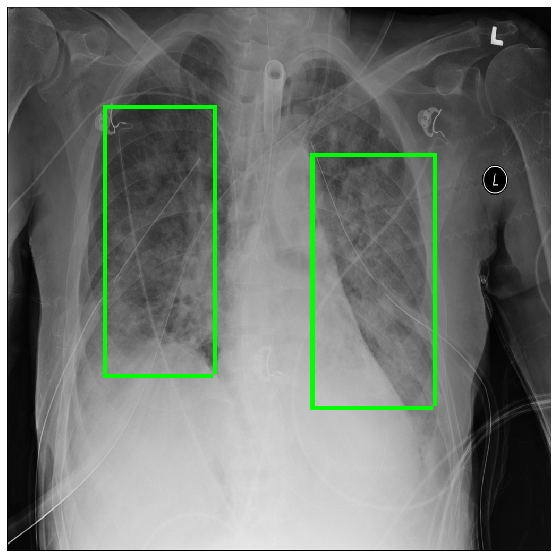

In [25]:
fig=plt.figure(figsize=(20, 10))
constructBoxes(parsed['00f08de1-517e-4652-a04f-d1dc9ee48593'])
plt.show()

In [26]:
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
import csv

In [27]:
pneumonia_locations = {}
# load table
with open(os.path.join('C:/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [28]:
folder = 'C:/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images'
filenames = os.listdir(folder)
print(len(filenames))
# split into train and test filenames
test = int(len(filenames) * 0.2)
print(test)
train = filenames[test:]
test = filenames[:test]
print('train', len(train))
print('test', len(test))

26684
5336
train 21348
test 5336


In [29]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=320, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
    
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
            
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [30]:
BATCH_SIZE = 16
IMAGE_SIZE = 320

In [31]:
def downSample(channels, inputs):
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def resNet(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def myRESNET(input_size, channels, blocks=2, depth=3):
    #Input layer
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    #Residual layer
    for d in range(depth):
        channels = channels * 2
        x = downSample(channels, x)
        for b in range(blocks):
            x = resNet(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(256, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2DTranspose(128, (8,8), (4,4), padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(64,1, padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
    outputs = keras.layers.UpSampling2D(2**(depth-2))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [32]:
# create network and compiler
model = myRESNET(input_size=320, channels=32, blocks=2, depth=3)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#annealing cosine learning
def cosine_annealing(x):
    lr = 0.002
    epochs = 15
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
train_gen = generator(folder, train, pneumonia_locations, batch_size=16, image_size=320, shuffle=True, augment=True, predict=False)
test_gen = generator(folder, test, pneumonia_locations, batch_size=16, image_size=320, shuffle=False, predict=False)

print(model.summary())
                                                

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 64) 2048        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [33]:
myRESNET = model.fit_generator(train_gen, validation_data=test_gen, callbacks=[learning_rate], epochs=1, shuffle=True)

1334/1334 [==============================] - 27660s 21s/step - loss: 0.0935 - accuracy: 0.9761 - val_loss: 0.1482 - val_accuracy: 0.9601


In [40]:
duplicate_RESNET = myRESNET

In [34]:
print(myRESNET.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [39]:
print(myRESNET.history['accuracy'])
print(myRESNET.history['val_accuracy'])


[0.97607964]
[0.96008945]


In [213]:
forSVM_df.shape
forSVM_df.sample(20)
forSVMFinal_df = forSVM_df.drop('class', axis = 1).copy()
forSVMFinal_df.sample(20)

,patientId,x,y,width,height,Target
3522,38dee97d-933d-48f7-8f77-dbb7bc9b2776,226.0,375.0,169.0,199.0,1
6784,51bccfa7-c788-4b2e-b5e6-17db32b1009e,359.0,303.0,177.0,258.0,1
27243,f21cbf1d-6943-4840-8de8-2d407e638e65,NaN,NaN,NaN,NaN,0
3549,390dad2f-bd13-4f16-92af-4e061499eddc,246.0,130.0,210.0,514.0,1
21808,c5bca0c4-2fa0-437a-b92c-b037a6f9613e,NaN,NaN,NaN,NaN,0
2372,3186d210-966f-4733-ba72-98729be9551a,175.0,482.0,170.0,289.0,1
3488,38b147a7-352b-4adb-88b5-2449d362acae,187.0,565.0,192.0,332.0,1
19246,b359c695-5814-4c1e-a7c0-200509182a4f,313.0,179.0,170.0,358.0,1
4211,3d5e4188-b4c2-41b1-81fe-a48f6271fe47,548.0,341.0,222.0,571.0,1
10975,733320d8-8270-4171-b6f3-7ab2eda1e109,246.0,503.0,165.0,132.0,1


In [205]:
detailed_class_info = pd.read_csv('C:/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('C:/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

df = pd.merge(left = detailed_class_info, right = train_labels, how = 'left', on = 'patientId')

del detailed_class_info, train_labels
gc.collect()

df = df.drop_duplicates()
df_meta = df.drop('class', axis = 1).copy()
df_meta.sample(20)

,patientId,x,y,width,height,Target
14211,762f405c-b9fc-4b1c-abf0-a6c5a3f92b16,NaN,NaN,NaN,NaN,0
8829,4ff93b63-f90a-4b02-9075-d8b0b5ce6e4b,NaN,NaN,NaN,NaN,0
22852,add89c20-44cf-461a-9857-c41d753d4062,553.0,308.0,271.0,577.0,1
33555,f02b6a5c-f922-4334-ac80-99d7418c41f0,653.0,522.0,157.0,126.0,1
10094,59246843-0853-43aa-8952-059aecfc2bdc,NaN,NaN,NaN,NaN,0
14767,79b34f64-0c0b-458b-82c3-95f938d3ab08,NaN,NaN,NaN,NaN,0
35386,fcabeae4-2631-494c-b7f9-f96d6da5e0ab,NaN,NaN,NaN,NaN,0
36405,1325b50a-3e35-41a6-a871-40359dccf55e,NaN,NaN,NaN,NaN,0
30534,d9f275f9-4f05-485d-8401-810b9f07a13c,NaN,NaN,NaN,NaN,0
27551,c43a67f1-188f-42d4-84fa-022dcc577ae3,NaN,NaN,NaN,NaN,0


In [208]:

for n, pid in enumerate(df_meta['patientId'].unique()):
    dcm_file = 'C:/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid
    dcm_data = pydicom.read_file(dcm_file)
    
    if not dcm_columns:
        dcm_columns = dcm_data.dir()
        dcm_columns.remove('PixelSpacing')
        dcm_columns.remove('PixelData')
    
    for col in dcm_columns:
        if not (col in df_meta.columns):
            df_meta[col] = np.nan
        index = df_meta[df_meta['patientId'] == pid].index
        df_meta.loc[index, col] = dcm_data.data_element(col).value
        
    del dcm_data
    
gc.collect()

df_meta.head()


,patientId,x,y,width,height,Target,PatientSex,AccessionNumber,BitsAllocated,BitsStored,...,SamplesPerPixel,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,F,,8.0,8.0,...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.28530.15178744...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.28530.15178744...,000000.00,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,F,,8.0,8.0,...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.26024.15178744...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.26024.15178744...,000000.00,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,M,,8.0,8.0,...,1.0,view: AP,1.2.276.0.7230010.3.1.3.8323329.11252.15178743...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.11252.15178743...,000000.00,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,M,,8.0,8.0,...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.2293.151787429...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.2293.151787429...,000000.00,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,F,,8.0,8.0,...,1.0,view: AP,1.2.276.0.7230010.3.1.3.8323329.6379.151787432...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.6379.151787432...,000000.00,AP


In [209]:
df_meta.shape

(30227, 39)

In [215]:
def dicomEachPatient(pid):
    return pydicom.read_file('C:/Users/mayur/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid)

def getMetaData(pid, columns):
    dicom = dicomEachPatient(pid)
    wantedColumn = getattr(dicom, columns)
    return wantedColumn

In [226]:
columns = ['PatientSex', 'PatientAge', 'ViewPosition']
for i in columns:
    forSVMFinal_df[i] = forSVMFinal_df['patientId'].apply(lambda l: getMetaData(l, i))
forSVMFinal_df['PatientAge'] = forSVMFinal_df['PatientAge'].apply(pd.to_numeric, errors='coerce')
forSVMFinal_df['PatientAge'] = forSVMFinal_df['PatientAge'].apply(lambda l: l if l<120 else np.nan)


In [229]:
forSVMFinal_df.head()

,patientId,x,y,width,height,Target,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,F,32.0,AP


In [231]:
svmDuplicate_df = forSVMFinal_df

In [233]:
svmDuplicate_df.sample(20)

,patientId,x,y,width,height,Target,PatientSex,PatientAge,ViewPosition
8455,5f866831-9057-4be0-ae41-8164062a0a22,NaN,NaN,NaN,NaN,0,M,32.0,PA
12831,81f89fe4-78c8-409b-8f4e-e20588818fa1,143.0,153.0,293.0,717.0,1,M,29.0,AP
806,0a8b9570-2684-48e1-b016-e14a6a79cd3e,NaN,NaN,NaN,NaN,0,F,52.0,AP
24737,de2b54b9-114f-4f68-9a5f-4602e843cc31,NaN,NaN,NaN,NaN,0,M,21.0,PA
22016,c77fa013-13f4-4da2-8f6d-b2c42299cf53,NaN,NaN,NaN,NaN,0,F,45.0,PA
27444,f3bab5d5-efa1-4868-b207-b649b0df3577,NaN,NaN,NaN,NaN,0,M,46.0,PA
1100,0cb75033-7ff0-4f4b-938f-cb6b58bf7fdb,NaN,NaN,NaN,NaN,0,F,29.0,AP
19146,b29dcdc8-57c8-443a-a69c-615fa7dc9973,603.0,484.0,225.0,257.0,1,M,36.0,PA
26894,ef626000-1335-4c85-b17a-2c0b98e67a69,NaN,NaN,NaN,NaN,0,F,35.0,AP
22500,cb683934-8d2d-4cda-b996-55cfc8d012f6,515.0,245.0,319.0,425.0,1,M,66.0,AP


In [234]:
svmDuplicate_df['PatientSex'] = svmDuplicate_df['PatientSex'].map({'F': 0, 'M': 1}) 
svmDuplicate_df['ViewPosition'] = svmDuplicate_df['ViewPosition'].map({'PA': 0, 'AP': 1}) 

In [235]:
forSVMFinal_df.head()

,patientId,x,y,width,height,Target,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,0,51.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,0,48.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,19.0,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,28.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,0,32.0,1


In [236]:
svm_df = forSVMFinal_df[['PatientSex', 'PatientAge', 'ViewPosition', 'Target']]

In [240]:
svm_df.sample(20)

,PatientSex,PatientAge,ViewPosition,Target
6353,0,64.0,1,1
9958,0,66.0,0,0
6373,1,72.0,0,0
10428,0,60.0,0,1
14146,1,69.0,0,0
27675,1,57.0,1,0
11574,1,24.0,0,0
22994,0,50.0,1,0
13275,0,52.0,1,0
4746,0,58.0,0,0


In [244]:
svm_df = svm_df.dropna()
svm_df.to_csv('svmFinalFinal_df.csv', index = False)

AUC = 0.7504946732171016
AUC = 0.7053812349067736
AUC = 0.72335326762868
AUC = 0.7211128757310719
AUC = 0.7706573251569795
AUC = 0.7148129291762602
AUC = 0.7544859763372062
AUC = 0.706883867923382
AUC = 0.7697279018336325
AUC = 0.7371484727830951
Mean AUC = 0.7354419938717915


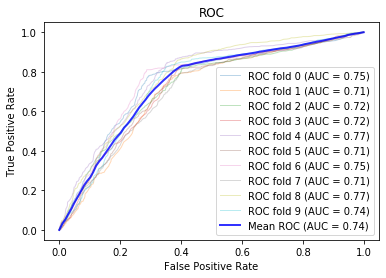

0.7012969825304394


In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
import numpy as np
import pandas as pd
from numpy import interp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

heart = pd.read_csv("svmFinalFinal_df.csv");
array = heart.values
X = array[:,0:3]
y = array[:,3]
n_samples, n_features = X.shape


# 10 fold cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression(max_iter=1000)
aucs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    figure = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, figure.fpr, figure.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(figure.roc_auc)
    print('AUC = ', end =""),
    print(float(figure.roc_auc))


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print('Mean AUC = ', end ="")
print(mean_auc)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC")
ax.legend(loc="lower right")
plt.show()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)
print(score)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
heart = pd.read_csv("svmFinalFinal_df.csv");
array = heart.values
X = array[:,0:3]
y = array[:,3]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)
svm_model = SVC(kernel='rbf', gamma=0.1, C=1.0)
svm_model.fit(x_train, y_train)
predictions = svm_model.predict(x_test)
score = svm_model.score(x_test, y_test)
print('Accuracy =',score)